In [1]:
%matplotlib inline

# define relevant packages; among others: JIRA API
import pandas as pd
import numpy as np
from jira import JIRA 
import matplotlib.pyplot as plt
import mwtools as mt

import seaborn as sns


# ToDos
- [ ] create filters and apply them to a dataframe wo/changing the dataframe itself 

/Example:/
```
price_filter = df.loc[:, 'price'] <= 3000000
df.loc[price_filter, 'price'].hist(bins = 30)
```
- [ ] measure balance sheet for provided hours and billed hours

 # AERQ Business Owner Reporting Notebook

 ## CMS related reports

### Procon hours

#### Monthly booked hours in a table

---
** Attention: currently, the below figures come from a test excel sheet only! **
** They do currently not reflect any real spent CMS effort **

---

In [2]:
df_procon = pd.read_excel('./AERQ.commercials.overview.xlsx', sheet_name='Procon LTE Data', usecols="A:L")
df_procon.shape

(228, 12)

In [3]:
print (df_procon['LE-Bezeichnung'].value_counts())
#from all Procon LEs, filter the CMS entries only
cms_filter = df_procon['LE-Bezeichnung'] == 'AERQ Product'
# and check, how many entries are affected
cms_filter.shape


AERQ ModServer                    56
AERQ Consulting                   55
AERQ SW Architect & Deploy FRA    53
AERQ Product                      31
AERQ Sales Support                21
RFC BC Core Mod Experte            5
AERQ OpsUI BUD                     4
AERQ Virtual Aircraft              2
RFC BC Core Mod Sen Entw           1
Name: LE-Bezeichnung, dtype: int64


(228,)

In [4]:
# get the number of employees that have booked hours for the filtered Procon LE
no_staff = len(df_procon.loc[cms_filter, ['Mitarbeiter-Name']].value_counts())
# sum up the booked hours and print 'em out
no_hours = df_procon.loc[cms_filter, ['Stunden']].sum()
print(str(no_staff)+' colleagues have booked a total of '+str(no_hours))
df_procon.loc[cms_filter, :].groupby(by=['Export-Datum', 'Mitarbeiter-Name'])[['Stunden']].sum()

6 colleagues have booked a total of Stunden    153.47
dtype: float64


Stunden
Export-Datum Mitarbeiter-Name              
2020-06-26   Kohlert, Christian        5.50
             Pietzner, Mark            8.00
             Thiel, Gregor Michael     2.00
             Weil, Mario              33.50
2020-07-29   Kohlert, Christian        5.00
             Pietzner, Mark            1.00
2020-08-27   Droege, Eberhard          2.00
             Kohlert, Christian        1.00
             Pietzner, Mark           23.90
2020-09-28   Pietzner, Mark           11.00
             Thiel, Gregor Michael     5.50
             Weil, Mario               1.00
2020-10-27   Pietzner, Mark            1.00
             Thiel, Gregor Michael     1.00
2020-11-27   Kohlert, Christian       13.42
             Pietzner, Mark            2.00
             Thiel, Gregor Michael     1.50
2020-12-27   Kohlert, Christian       13.42
             Pietzner, Mark            2.00
             Thiel, Gregor Michael     1.50
2021-01-27   Kohlert, Christian        3.00
             Scherf, Sven             15.23

In [5]:
print (df_procon['Stunden'].value_counts())


1.00     23
2.00     15
4.00     14
3.50     12
1.50     11
         ..
16.50     1
23.50     1
9.75      1
97.50     1
51.00     1
Name: Stunden, Length: 98, dtype: int64


#### Monthly booked hours in a chart (2020)

No handles with labels found to put in legend.


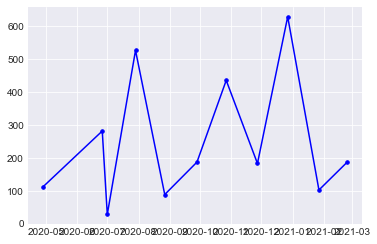

In [6]:
#type(df_procon.groupby(by=['Export-Datum'])[['Stunden']].sum())
#plt.style.available
plt.style.use('seaborn-darkgrid')
plt.legend(loc='center right')
plt.plot(df_procon.groupby(by=['Export-Datum'])[['Stunden']].sum(), c='b', marker = '.', markersize=7)

 ### Velocity per product in current Sprint: AERQ, DISP, BC

In [7]:
# JQL: retrieve all tickets in current Sprint
search_string = 'project = BCIFCPCMS AND Sprint in (openSprints()) ORDER BY sprint'


**JQL Statement**
```
project = BCIFCPCMS AND Sprint in (openSprints()) ORDER BY sprint
```

In [8]:
# create DataFrame with relevant attributes from which further reports are derived
df = pd.DataFrame()
try:
    jiraBc = mt.ts_connect()
    df = mt.cat_cms_tickets(jiraBc, search_string)
except Exception as e:
    print(e)



#### Velocity table and chart per category

The chart shows tickets in current Sprint

            Story Points      %
Labels                         
AERQ                37.0  48.05
BC                  32.0  41.56
DISP@LH777           8.0  10.39


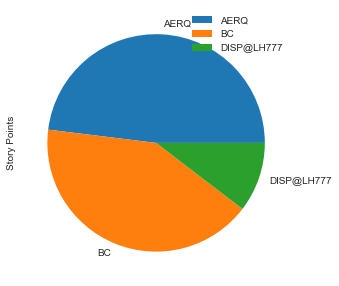

In [9]:
    # group selected tickets (current, future sprints) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


#### Tickets in current Sprint

In [10]:
# Width of the display in characters. If set to None and pandas will correctly auto-detect the width.
pd.set_option('display.width', None)
print (df[['Key', 'Story Points', 'Labels']])

               Key  Story Points      Labels
0   BCIFCPCMS-4587           8.0        AERQ
1   BCIFCPCMS-4506           8.0          BC
2   BCIFCPCMS-4596           8.0        AERQ
3   BCIFCPCMS-4479          13.0          BC
4   BCIFCPCMS-4585           5.0        AERQ
5   BCIFCPCMS-4635           3.0  DISP@LH777
6   BCIFCPCMS-4534           3.0          BC
7   BCIFCPCMS-4615           0.0  DISP@LH777
8   BCIFCPCMS-4613           3.0          BC
9   BCIFCPCMS-4610           8.0        AERQ
10  BCIFCPCMS-4578           5.0        AERQ
11  BCIFCPCMS-4582           3.0        AERQ
12  BCIFCPCMS-4598           5.0          BC
13  BCIFCPCMS-4609           5.0  DISP@LH777


 ### Velocity per product in refined items: AERQ, DISP, BC

In [12]:
# JQL: get all tickets which have label "refined" and that are in the backlog
search_string = 'project = BCIFCPCMS AND issuetype not in subtaskIssueTypes() AND issuetype != Epic AND resolution = Unresolved AND (Sprint = EMPTY OR Sprint not in (openSprints(), futureSprints())) AND labels in ("refined")'

**JQL Statement**
```
project = BCIFCPCMS AND issuetype not in subtaskIssueTypes() AND issuetype != Epic AND resolution = Unresolved AND (Sprint = EMPTY OR Sprint not in (openSprints(), futureSprints())) AND labels in ("refined")
```

In [13]:
# create DataFrame with relevant attributes from which further reports are derived
df = pd.DataFrame()
try:
    jiraBc = mt.ts_connect()
    df = mt.cat_cms_tickets(jiraBc, search_string)
except Exception as e:
    print(e)


#### Velocity table and chart per category

The chart shows refined items in Backlog

            Story Points      %
Labels                         
AERQ                49.0   7.69
BC                 555.0  87.13
DISP@LH777          33.0   5.18


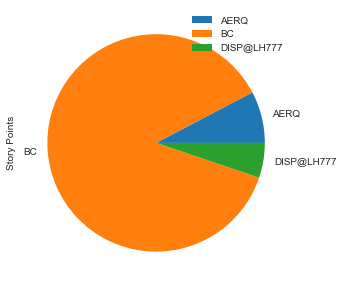

In [14]:
    # group selected tickets (current, future sprints) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


 ### Velocity per product in future Sprints: AERQ, DISP, BC

In [16]:
# JQL: get all non-closed tickets from future Sprints (thus: Refined Sprint (doesn't exist any longer; instead, label "refined" is used), existing Sprints > current one)
search_string = 'project = BCIFCPCMS AND Sprint in (futureSprints()) AND status not in (Done, Closed, Resolved) ORDER BY sprint'


**JQL Statement**
```
project = BCIFCPCMS AND Sprint in (futureSprints()) AND status not in (Done, Closed, Resolved) ORDER BY sprint
```

In [18]:
# create DataFrame with relevant attributes from which further reports are derived
df = pd.DataFrame()
try:
    jiraBc = mt.ts_connect()
    df = mt.cat_cms_tickets(jiraBc, search_string)
except Exception as e:
    print(e)



#### Velocity table and chart per category

The chart shows tickets in future Sprints (refined items that have already been planned in future Sprints)

        Story Points      %
Labels                     
AERQ            26.0  38.24
BC              42.0  61.76


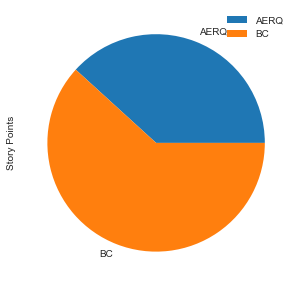

In [19]:
    # group selected tickets (current, future sprints) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


 ### Velocity per product in past month per category: AERQ, DISP, BC

In [21]:
from datetime import date, timedelta

previous_month = date.today().replace(day=1) - timedelta(days=1)
# create DataFrame with relevant attributes from which further reports are derived
search_string = ('project = BCIFCPCMS AND '
'status changed TO (resolved, done, closed) '
'AFTER "' + str(previous_month.year) + '/' + str(previous_month.month) + '/' + '01" '
'BEFORE "' + str(previous_month.year) + '/' + str(previous_month.month) + '/' + str(previous_month.day) + '" '
'ORDER BY  updated DESC')


**JQL Statement**
```
project = BCIFCPCMS AND status changed to (resolved, done, closed) after "yyyy/mm-1/1" before "yyyy/mm-1/<end_of_month>" ORDER BY updated DESC" 
```

In [22]:
df = pd.DataFrame()
try:
    jiraBc = mt.ts_connect()
    df = mt.cat_cms_tickets(jiraBc, search_string)
except Exception as e:
    print(e)


#### Velocity table and chart per category

3 2021
            Story Points      %
Labels                         
AERQ                97.0  50.26
BC                  86.0  44.56
DISP@LH777          10.0   5.18


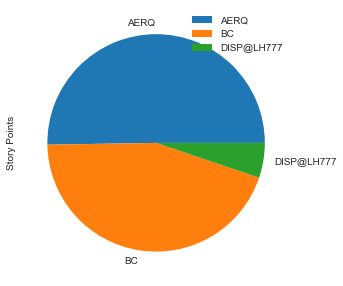

In [23]:
    # group selected tickets (previous month) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print (str(previous_month.month) + ' ' + str(previous_month.year))
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


 ### Velocity per product in current month per category: AERQ, DISP, BC

In [25]:
current_month = date.today()
search_string = ('project = BCIFCPCMS AND '
'status changed TO (resolved, done, closed) '
'AFTER "' + str(current_month.year) + '/' + str(current_month.month) + '/' + '01" '
'BEFORE "' + str(current_month) + '" '
'ORDER BY  updated DESC')

**JQL Statement**
```
project = BCIFCPCMS AND status changed to (resolved, done, closed) after "yyyy/mm/1" before "yyyy/mm-1/<today>" ORDER BY updated DESC 
```

In [26]:
df = pd.DataFrame()
try:
    jiraBc = mt.ts_connect()
    df = mt.cat_cms_tickets(jiraBc, search_string)
except Exception as e:
    print(e)


Length mismatch: Expected axis has 0 elements, new values have 7 elements


#### Velocity table and chart per category

In [27]:
    # group selected tickets (current month) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    if df.empty:
        print('In current month, no tickets have been processed so far')
    else:
        df_new = df.groupby('Labels')[['Story Points']].sum()
        # add a Velocity's percentage value per category
        df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
        print (str(current_month.month) + ' ' + str(current_month.year))
        print(df_new)
        plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


In current month, no tickets have been processed so far
